# Packed bed reactors in Cantera

In this example we simulate a packed bed reactor (PBR) using a series of continuously stirred tank reactors (CSTRs). This technique makes use of the following advanced functionality in Cantera: 

1. Simulating multiphase thermodynamics and reaction mixtures using Cantera
2. Using a Cantera reactor network object to work with our two-phase system

The design equation for a PBR is as follows: 

$$W_{cat} = F_{A0}\int_{0}^{X} \frac{dX}{-r'_A}$$

and the equation for a fluidized CSTR is:

$$W_{cat} = F_{A0} \frac{F_{A0}X}{-r'_A}$$

Comparing both of these on a Levenspiel plot shows that the limiting case for a large number of CSTRs (with differentially small volumes) in series will yield an approximation of a PBR: 

<img src="./images/levenspiel_plot.png"  width="500">

In [1]:
import cantera as ct

%matplotlib notebook
import matplotlib.pyplot as plt

print(f"Using Cantera version: {ct.__version__}")

Using Cantera version: 2.5.1


## Cantera Simulation Steps

As usual for a Cantera simulation, there are 3 main steps:

1. Create the appropriate phases from an input file
2. Set the initial conditions for the simulation
3. Run the simulation

### Inputs

To start, we will specify the inputs for the packed bed reactor:

- the reactor dimensions (radius, length, and catalyst bed area)
- the catalyst properties (surface area to volume ratio) 
- inlet conditions (flowrate, mole fractions)
- solver specifications (number of CSTRs we will use to approximate a PFR, time step size)

In [2]:
# Inputs 
temp = 700.0           # Temperature (K)
length = 0.3           # Catalyst bed length (m)
area = 1.0e3           # Catalyst bed total area (m^2)
cat_area_per_vol = 10  # Catalyst particle surface area per unit volume (m^2/m^3)
velocity = 0.4         # Gas velocity (m/s)
porosity = 0.3         # Catalyst bed porosity (unitless) 

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 201

### Create Cantera phases and set initial conditions

For this problem, we need both a surface phase and a gas phase. Most conveniently, these phase definitions will be in the same input file and the phase can be chosen by specifying the phase name. You will create a gas bulk phase using the `methane_pox_on_pt.yaml` example input file distributed with Cantera. Then, you will create a surface phase from the same input file.

The names of the phases correspond with the `name` field from the YAML input file. For our example, we have 2 phases named `gas` and `Pt_surf`:

```
phases:
- name: gas
  thermo: ideal-gas
  # Further input removed for space
- name: Pt_surf
  thermo: ideal-surface
  # Further input removed for space
```

First, you will specify the temperature, pressure, and concentrations for the gas phase. Then, specify the temperature and pressure for the surface phase.

In [14]:
yaml_file = 'methane_pox_on_pt.yaml'

gas = ct.Solution(yaml_file, 'gas')
gas.TPX = temp, ct.one_atm, 'CH4:1, O2:1.5, AR:0.1'

When creating a `Solution`, the _second_ argument tells Cantera which phase to load from the input file. By default, Cantera chooses the first, but when there are multiple phases present it is good practice to be explicit.

Surface phases are loaded using the `Interface` class. As with the `Solution`, the first and second arguments are the input file name and the phase name, respectively. For an `Interface`, the third argument must be a list of the adjacent bulk phase instances. In this case, we will use the variable `gas`.

In [4]:
surf = ct.Interface(yaml_file, 'Pt_surf', [gas])
surf.TP = temp, ct.one_atm

After initializing the gas and surface phases, we next want to calculate the differential volume and the differential length of differential CSTR elements. Additionally, the catalyst area and inlet mass flow rate need to be calculated.

In [5]:
rlen = length / (NReactors - 1)  
rvol = area * rlen * porosity
cat_area = cat_area_per_vol * rvol
mass_flow_rate = velocity * gas.density * area

### Practical Troubleshooting 
What is often good practice for solving a steady state model like this one is supplying an educated guess for the equilibrium surface coverage. This can be done by advancing the coverages in the first reactor. Notice that the initial state is 99% adsorbed hydrogen atom and 1% platinum sites.

In [6]:
surf()


  Pt_surf:

       temperature   700 K
          pressure   1.0133e+05 Pa
           density   5.3334e-06 kg/m^3
  mean mol. weight   196.08 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.6509e+05       -3.2371e+07  J
   internal energy       -1.6509e+05       -3.2371e+07  J
           entropy            40.394            7920.6  J/K
    Gibbs function       -1.9336e+05       -3.7915e+07  J
 heat capacity c_p            75.829             14869  J/K
 heat capacity c_v            75.829             14869  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             PT(S)         0.0099491              0.01           -4.6052
              H(S)           0.99005              0.99           -6.5338
     [   +9 minor]                 0                 0  



In [7]:
surf.advance_coverages(1.0)
surf()


  Pt_surf:

       temperature   700 K
          pressure   1.0133e+05 Pa
           density   5.6535e-06 kg/m^3
  mean mol. weight   207.85 kg/kmol
   phase of matter   unspecified

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -4.1524e+05       -8.6307e+07  J
   internal energy       -4.1524e+05       -8.6307e+07  J
           entropy             114.3             23757  J/K
    Gibbs function       -4.9525e+05       -1.0294e+08  J
 heat capacity c_p            80.174             16664  J/K
 heat capacity c_v            80.174             16664  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
             PT(S)           0.22691           0.24176           -1.4198
              H(S)        1.2149e-05        1.2877e-05           -17.784
            H2O(S)          6.67e-06        6.5058e-06     

Alternatively, if one has a guess for the initial coverage, they may specify it similar to how the gas phase mole fractions are specified. Note that like mole fractions, surface coverages are normalized so that they sum to 1.0.

In [8]:
surf.coverages = 'PT(S):0.1, H(S):0.9'

### Creating a chain of CSTRs to approximate a PFR
The plug flow reactor is represented by a linear chain of zero-dimensional reactors. The gas at the inlet to the first one has the specified inlet composition, and for all others the inlet composition is fixed at the composition of the reactor immediately upstream. Since in a PFR model there is no diffusion, the upstream reactors are not affected by any downstream reactors, and therefore the problem may be solved by simply marching from the first to last reactor, integrating each one to steady state.

<img src="./images/Chain_of_CSTRs.png"  width="700">

Next, we need to initialize our reactor objects of the type 'IdealGasReactor'. We also need to attach a surface onto it to run all surface reactions simultaneously. 

In [9]:
r = ct.IdealGasReactor(gas, energy='off')
r.volume = rvol

rsurf = ct.ReactorSurface(surf, r, A=cat_area)

Next, create two reservoirs: one for the supply gas (upstream) and one for the outlet (downstream). To control our material balance across the reactor, we will need to introduce the `MassFlowController` and the `PressureController` objects. The mass flow rate in the `MassFlowController` is constant here.

In [10]:
upstream = ct.Reservoir(gas, name='upstream')

downstream = ct.Reservoir(gas, name='downstream')

m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

v = ct.PressureController(r, downstream, master=m, K=1e-5)

We will then create a `ReactorNet` object.

In [11]:
sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-9
sim.atol = 1.0e-21

We are now ready to run our reactor. We will print the CH4, H2, and CO mile fractions so we can track our progress down the PBR. We will also record our data while the reactor is running.

In [12]:
print('    distance       X_CH4        X_H2        X_CO')

states = ct.SolutionArray(gas, extra=['distance'])

# run each differential reactor volume element sequentially
for n in range(NReactors):
    
    # Set the state of the reservoir to match that of the previous reactor. 
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    sim.reinitialize()

    # run the CSTR to steady state, since we are getting 
    # our steady state concentrations in the PFR
    sim.advance_to_steady_state()
    dist = n * rlen * 1.0e3  # distance in mm

    # generate our solution array using the states object
    states.append(r.thermo.state, distance=dist)

    if n % 10 == 0:
        print('  {0:10f}  {1:10f}  {2:10f}  {3:10f}'.format(
            dist, *gas['CH4', 'H2', 'CO'].X))

    distance       X_CH4        X_H2        X_CO
    0.000000    0.370772    0.009461    0.000021
   15.000000    0.284419    0.028281    0.000020
   30.000000    0.228614    0.022339    0.000015
   45.000000    0.187691    0.016497    0.000013
   60.000000    0.158090    0.012009    0.000011
   75.000000    0.137209    0.008714    0.000010
   90.000000    0.122852    0.006370    0.000009
  105.000000    0.113211    0.004753    0.000008
  120.000000    0.106867    0.003667    0.000008
  135.000000    0.102760    0.002953    0.000007
  150.000000    0.100132    0.002491    0.000007
  165.000000    0.098465    0.002196    0.000007
  180.000000    0.097414    0.002010    0.000007
  195.000000    0.096754    0.001893    0.000007
  210.000000    0.096340    0.001820    0.000007
  225.000000    0.096080    0.001774    0.000008
  240.000000    0.095918    0.001746    0.000008
  255.000000    0.095816    0.001729    0.000009
  270.000000    0.095752    0.001719    0.000010
  285.000000    0.09

## Results

Plot the resulting surface coverages and concentrations over the length of the PFR using our `states` solution array

<IPython.core.display.Javascript object>


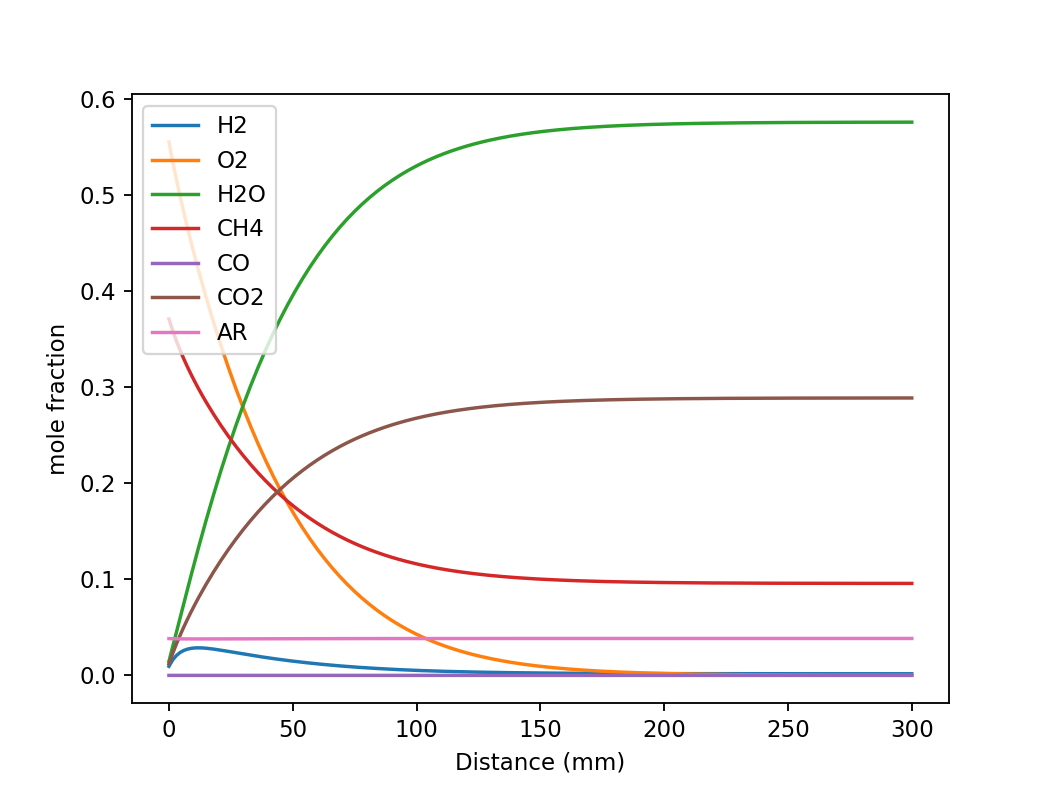

In [13]:
for i in range(gas.n_species):
    spec = gas.species_names[i]
    plt.plot(states.distance, states.X[:,i],label = spec)
    plt.legend()

plt.xlabel("Distance (mm)")
plt.ylabel("mole fraction")
plt.show()